# KX Equity Analytics for ICE® Data Accelerator API Examples

This notebook demonstrates calling the FSI `generateOrderAnalytics()` and `getOrderAnalyticSummary()` Library APIs via REST for the KX Equity Analytics for ICE® Data Accelerator. You will need a running instance of kdb Insights Enterprise with the Accelerator deployed.

> Service account credentials are required to authorize requests. More detail on creating them is available on our page about [managing service accounts](https://code.kx.com/insights/1.11/enterprise/security/managing-service-accounts.html), or speak with your kdb Insights Enterprise administrator.

kdb Accelerators are packages for kdb products that address typical industry use cases. Using an Accelerator allows you to leapfrog the first phases of a project or Insights implementation, skipping common boilerplate or initial effort and jumping straight to value adding work. They are a customization-first approach to developing on kdb products, helping you learn and unlock the value of KX products faster.

You can read more about the Accelerator in the [KX Equity Analytics for ICE® Data Accelerator](https://code.kx.com/insights/accelerators/fsi/ice-eqea-introduction.html).


---
### Imports, Constants, Helper Function, & Authentication
> `Tip:` run pip install -r requirements.txt

In [2]:
# Python library imports
import os
import requests
import json
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timezone, timedelta
from requests_oauth2client import OAuth2Client, OAuth2ClientCredentialsAuth
from getpass import getpass
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

You should edit the constants below to reflect your particular kdb Insights instance details. You will be prompted for a Client and Secret.

In [3]:
# Constants - set these as appropriate
INSIGHTS_HOST   = '<HOST>' # Your Insights Enterprise hostname
INSIGHTS_REALM  = '<REALM>' # Your Insights realm, typically 'insights'
INSIGHTS_CLIENT = input("kdb Insights client: ")           # Your insights client (service account name)
INSIGHTS_SECRET = getpass("kdb Insights client secret: ")  # Your insights secret

In [4]:
# Authentication
oauth2client = OAuth2Client(
    token_endpoint='https://' + INSIGHTS_HOST + '/auth/realms/' + INSIGHTS_REALM + '/protocol/openid-connect/token',
    auth=(INSIGHTS_CLIENT, INSIGHTS_SECRET))
oauth2cc = OAuth2ClientCredentialsAuth(oauth2client, scope='roles')

---
## Using `getTicks()`
---

### REST API call to retrieve Quote data via getTicks

In [8]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": "2024.07.17D00:00:00.000000000",
  "endTS": "2024.07.17D23:59:59.999999999",
  "idList": ["E:3GOO"]
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getTicks', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadGetTicks = json.loads(r.text)['payload']

It is best practice when calling the APIs is to always check the header for errors - [code.kx.com](https://code.kx.com) has more information kdb Insights Enterprise [response codes and errors](https://code.kx.com/insights/1.10/api/database/api/codes.html#return-code), and also has an [Accelerators API Error Glossary](https://code.kx.com/insights/1.10/accelerators/fsi/error-glossary.html).

In [11]:
header

{'rcvTS': '2024-12-13T16:36:44.582000000',
 'corr': 'c81725bd-3651-48bb-b749-7f47b0889538',
 'protocol': 'gw',
 'entID': None,
 'logCorr': 'c81725bd-3651-48bb-b749-7f47b0889538',
 'client': ':10.37.133.14:5050',
 'http': 'json',
 'api': '.fsi.getTicks',
 'userName': 'eqea-demo-client',
 'userID': '5a72dc66-9051-4bd0-8b24-84246fba3d36',
 'retryCount': 0,
 'to': '2024-12-13T16:37:44.582000000',
 'agg': ':10.37.143.228:5070',
 'pvVer': 678,
 'rpID': 0,
 'refVintage': 1220133,
 'startTS': '2024-07-17T00:00:00.000000000',
 'endTS': '2024-07-17T23:59:59.999999999',
 'rc': 0,
 'ac': 0,
 'ai': ''}

In [12]:
dfPayloadGetTicks = pd.DataFrame(payloadGetTicks[0])
dfPayloadGetTicks

,eventTimestamp,instrumentID,bidPrice,bidSize,askPrice,askSize,srcSys
0,2024-07-17T06:58:28.347800064,E:3GOO,5335.25,1377.0,NaN,NaN,627
1,2024-07-17T06:58:28.347810048,E:3GOO,5335.25,1377.0,6793.00,1377.0,627
2,2024-07-17T06:59:38.012620032,E:3GOO,5335.25,1377.0,NaN,NaN,627
3,2024-07-17T06:59:38.012659968,E:3GOO,NaN,NaN,NaN,NaN,627
4,2024-07-17T07:00:00.459640064,E:3GOO,5389.00,900.0,NaN,NaN,627
...,...,...,...,...,...,...,...
145987,2024-07-17T15:35:21.816800128,E:3GOO,5280.00,47.0,5313.50,47.0,627
145988,2024-07-17T15:35:24.240430080,E:3GOO,5179.25,2751.0,5313.50,47.0,627
145989,2024-07-17T15:35:24.302409856,E:3GOO,5179.25,2751.0,5436.25,2751.0,627
145990,2024-07-17T16:30:00.228709888,E:3GOO,NaN,NaN,5436.25,2751.0,627


---
## Using Analytics
---

### REST API call to to generate Order Analytics from the Order table
This call calculates and returns Order Analytics.

> `Note:` This is similar to the Generation Pipelines' logic. The pipeline however, will persist the results into the OrderAnalytics table. We only recommend calling this function interactively to examine and explore the calculated analytics before storing them using the nightly generation & persistence pipeline. Always calculating them on-the-fly can be time consuming and resource intensive.

In [13]:
# Build arguments dictionary
args = {
  "table": "Order",
  "startTS": "2024.07.17D00:00:00.000000000",
  "endTS": "2024.07.17D23:59:59.999999999"
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/eqea/generateOrderAnalytics', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadOrderAnalytics = json.loads(r.text)['payload']

In [14]:
dfOrderAnalytics = pd.DataFrame(payloadOrderAnalytics[0])
dfOrderAnalytics

,strikeTime,instrumentID,orderID,tradeDate,exchangeID,MIC,ISIN,tradingVenueCode,executingBrokerCode,placementQty,...,reversionReturn_120,reversionReturn_180,reversionReturn_240,reversionReturn_300,reversionReturn_600,reversionReturn_900,reversionReturn_1200,reversionReturn_1500,reversionReturn_1800,reversionReturn_3600
0,2024-07-17T14:10:01.060710016,E:2MU,18151,2024-07-17,,,,tradingVenue_2,executingBroker_4,355,...,156.902700,167.474600,177.01510,134.08280,139.884500,141.818400,38.290960,108.684400,NaN,NaN
1,2024-07-17T07:00:33.927530112,E:3LLL,30433,2024-07-17,,,,tradingVenue_2,executingBroker_4,427,...,333.046500,324.440600,342.51290,309.81070,327.022400,303.786600,348.537000,311.531800,346.815800,453.528400
2,2024-07-17T15:27:01.568960000,E:3LLL,11293,2024-07-17,,,,tradingVenue_2,executingBroker_1,850,...,10.701350,11.524530,NaN,-52.68357,-6.585446,-6.585446,-6.585446,-6.585446,-6.585446,-6.585446
3,2024-07-17T08:59:24.983819904,E:3LRR,24406,2024-07-17,,,,tradingVenue_3,executingBroker_2,740,...,437.304000,261.179600,457.92350,436.44490,514.197300,514.197300,514.197300,514.197300,514.197300,514.197300
4,2024-07-17T09:57:06.652590080,E:3LUB,30656,2024-07-17,,,,tradingVenue_2,executingBroker_3,680,...,1529.223000,1516.354000,1532.44000,1559.24900,1516.354000,1516.354000,1516.354000,1516.354000,1516.354000,1516.354000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2024-07-17T12:03:38.095750144,E:WINE,1141,2024-07-17,,,,tradingVenue_1,executingBroker_2,592,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,-123.152700,-123.152700,-24.630540
96,2024-07-17T09:44:40.775140096,E:XS7R,12670,2024-07-17,,,,tradingVenue_3,executingBroker_3,423,...,-13.390000,-19.211740,-19.79391,-18.62956,-19.211740,-23.869130,-32.019560,-30.855210,-33.183910,-33.183910
97,2024-07-17T13:11:14.499079936,E:XS7R,19849,2024-07-17,,,,tradingVenue_1,executingBroker_1,493,...,7.563856,13.382210,13.96404,12.80037,13.382210,18.036890,26.182580,25.018910,27.346250,27.346250
98,2024-07-17T07:00:10.414020096,E:XZEU,23720,2024-07-17,,,,tradingVenue_1,executingBroker_2,62,...,5.701254,8.551881,14.25314,15.20334,5.701254,23.755230,9.502090,5.701254,-4.751045,15.203340


---
## Using Summary
---

### REST API call to retrieve summary data via custom API
This call rolls up and aggregates multiple order analytics for summary metrics

In [15]:
# Build arguments dictionary
args = {
  "table": "OrderAnalytics",
  "dt": "2024.07.17"
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/eqea/getOrderAnalyticSummary', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadSumAnalytics = json.loads(r.text)['payload']

In [16]:
dfSumAnalytics = pd.DataFrame(payloadSumAnalytics[0])
dfSumAnalytics.head()

,instrumentID,strikeTime,orderID,tradeDate,exchangeID,MIC,ISIN,tradingVenueCode,executingBrokerCode,placementQty,...,reversionReturn_120,reversionReturn_180,reversionReturn_240,reversionReturn_300,reversionReturn_600,reversionReturn_900,reversionReturn_1200,reversionReturn_1500,reversionReturn_1800,reversionReturn_3600
0,E:2MU,2024-07-17T14:10:01.060710016,18151,2024-07-17,,,,tradingVenue_2,executingBroker_4,355,...,156.90270,167.47460,177.0151,134.08280,139.884500,141.818400,38.290960,108.684400,NaN,NaN
1,E:2MU,2024-07-17T14:10:01.060710016,18151,2024-07-17,,,,tradingVenue_2,executingBroker_4,355,...,156.90270,167.47460,177.0151,134.08280,139.884500,141.818400,38.290960,108.684400,NaN,NaN
2,E:3LLL,2024-07-17T07:00:33.927530112,30433,2024-07-17,,,,tradingVenue_2,executingBroker_4,427,...,333.04650,324.44060,342.5129,309.81070,327.022400,303.786600,348.537000,311.531800,346.815800,453.528400
3,E:3LLL,2024-07-17T07:00:33.927530112,30433,2024-07-17,,,,tradingVenue_2,executingBroker_4,427,...,333.04650,324.44060,342.5129,309.81070,327.022400,303.786600,348.537000,311.531800,346.815800,453.528400
4,E:3LLL,2024-07-17T15:27:01.568960000,11293,2024-07-17,,,,tradingVenue_2,executingBroker_1,850,...,10.70135,11.52453,NaN,-52.68357,-6.585446,-6.585446,-6.585446,-6.585446,-6.585446,-6.585446


---
## Charts

## Plot using pre-generated orderAnalytics Data
This call uses the getData API to retreive pre-generated data from the orderAnalytics table

In [17]:
# Build arguments dictionary
args = {
  "table": "OrderAnalytics"
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/kxi/getData', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
orderAnalyticsData = json.loads(r.text)['payload']
dfOrderAnalyticsData = pd.DataFrame(orderAnalyticsData)

In [18]:
columns = [
    'reversionReturn_60', 'reversionReturn_120', 'reversionReturn_180', 'reversionReturn_240', 
    'reversionReturn_300', 'reversionReturn_600', 'reversionReturn_900', 'reversionReturn_1200', 
    'reversionReturn_1500', 'reversionReturn_1800', 'reversionReturn_3600'
]

avgReverstionReturnData = dfOrderAnalyticsData[['executingBrokerCode', *columns]]
avgReverstionReturnData

,executingBrokerCode,reversionReturn_60,reversionReturn_120,reversionReturn_180,reversionReturn_240,reversionReturn_300,reversionReturn_600,reversionReturn_900,reversionReturn_1200,reversionReturn_1500,reversionReturn_1800,reversionReturn_3600
0,executingBroker_4,156.129100,156.902700,167.474600,177.01510,134.08280,139.884500,141.818400,38.290960,108.684400,NaN,NaN
1,executingBroker_4,156.129100,156.902700,167.474600,177.01510,134.08280,139.884500,141.818400,38.290960,108.684400,NaN,NaN
2,executingBroker_4,331.325300,333.046500,324.440600,342.51290,309.81070,327.022400,303.786600,348.537000,311.531800,346.815800,453.528400
3,executingBroker_4,331.325300,333.046500,324.440600,342.51290,309.81070,327.022400,303.786600,348.537000,311.531800,346.815800,453.528400
4,executingBroker_1,14.817250,10.701350,11.524530,NaN,-52.68357,-6.585446,-6.585446,-6.585446,-6.585446,-6.585446,-6.585446
...,...,...,...,...,...,...,...,...,...,...,...,...
195,executingBroker_1,9.891197,7.563856,13.382210,13.96404,12.80037,13.382210,18.036890,26.182580,25.018910,27.346250,27.346250
196,executingBroker_2,0.000000,5.701254,8.551881,14.25314,15.20334,5.701254,23.755230,9.502090,5.701254,-4.751045,15.203340
197,executingBroker_4,0.000000,5.701254,8.551881,14.25314,15.20334,5.701254,23.755230,9.502090,5.701254,-4.751045,15.203340
198,executingBroker_2,0.000000,5.701254,8.551881,14.25314,15.20334,5.701254,23.755230,9.502090,5.701254,-4.751045,15.203340


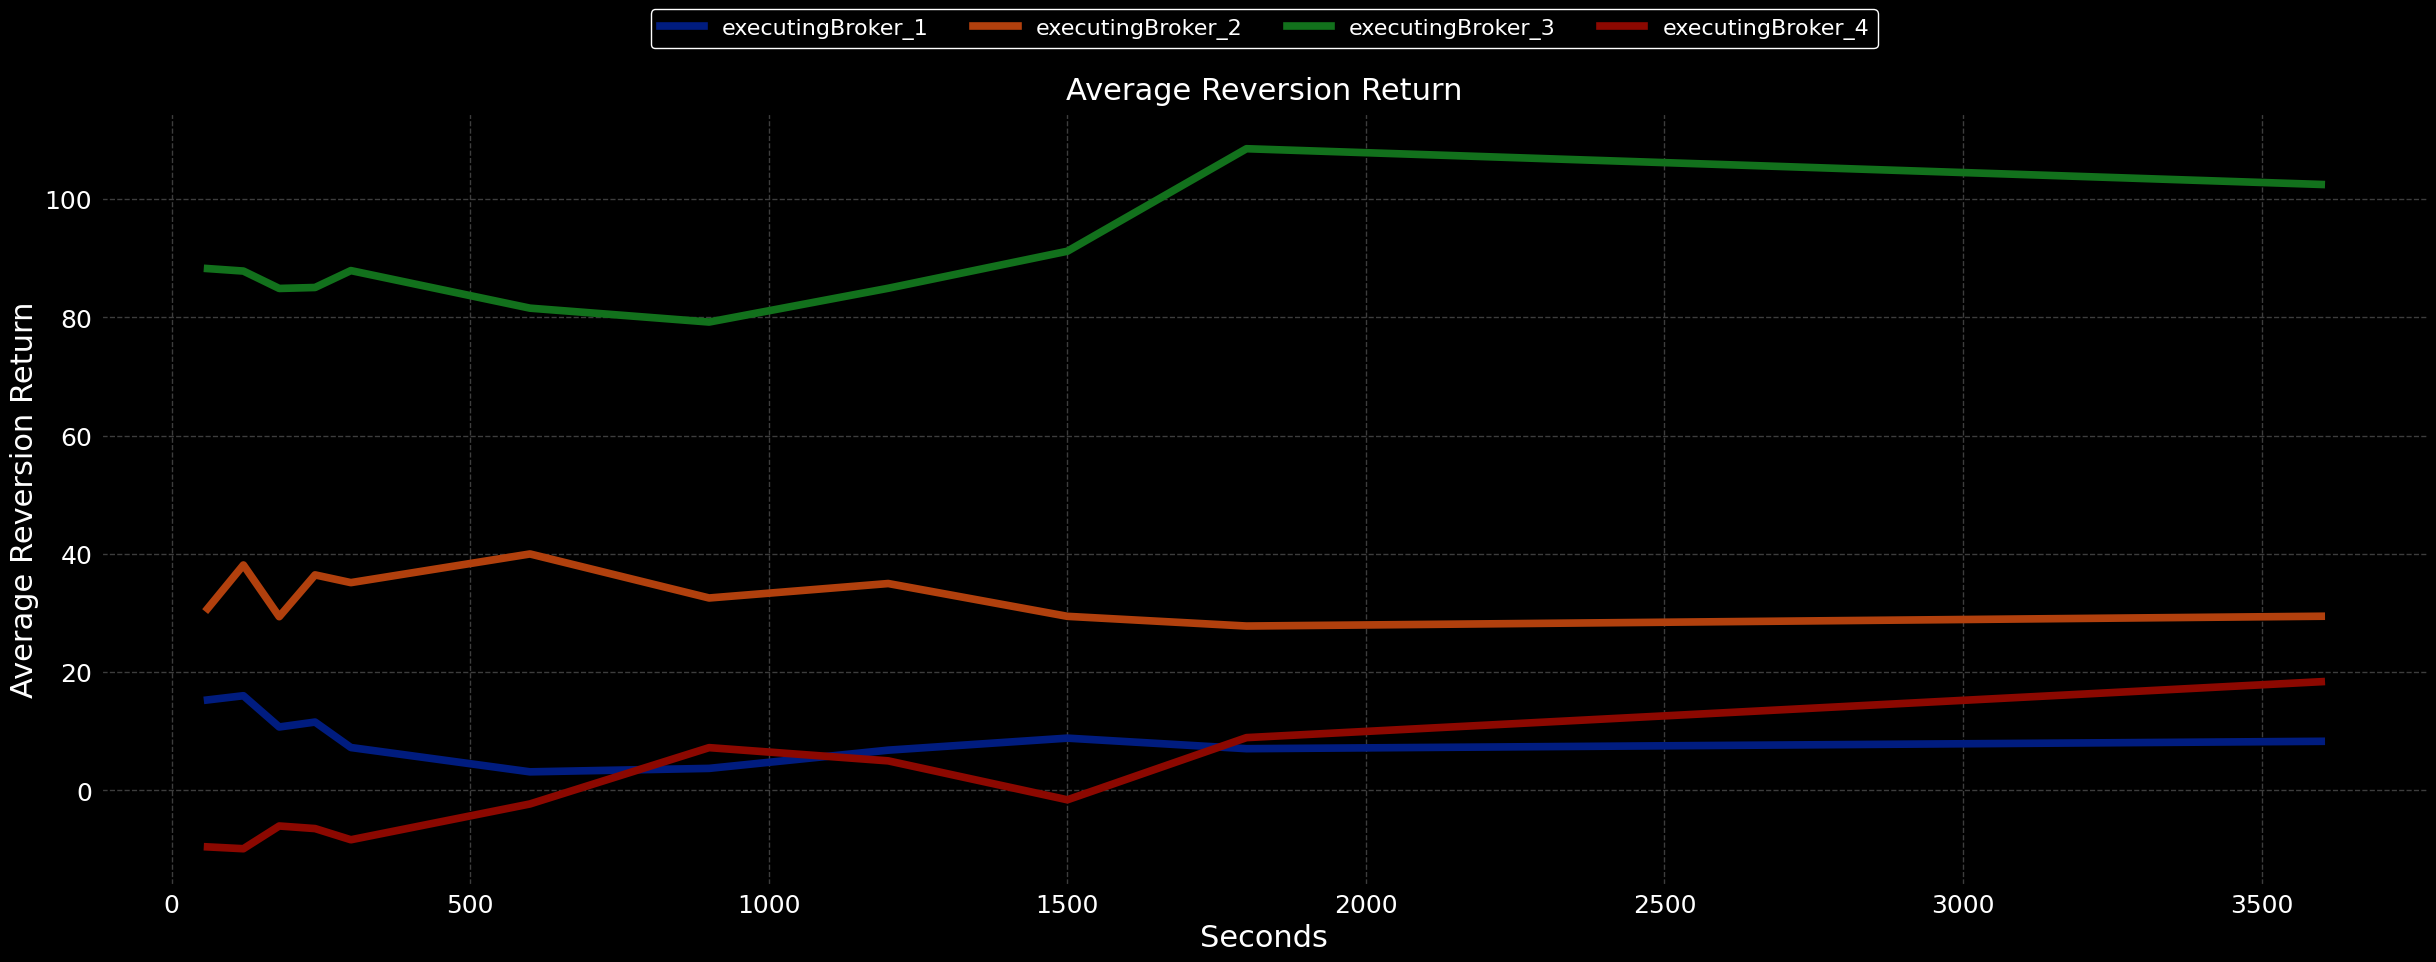

In [19]:
time_intervals = [int(col.split('_')[1]) for col in columns]

plt.figure(figsize=(30, 10))
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
colors = sns.color_palette("dark", len(avgReverstionReturnData['executingBrokerCode'].unique()))

for i, (venue, group_data) in enumerate(avgReverstionReturnData.groupby('executingBrokerCode')):
    avg_values = group_data[columns].mean()
    plt.plot(time_intervals, avg_values, label=venue, color=colors[i], linewidth=5.5)

plt.title('Average Reversion Return', color='white', pad=10.0, fontsize="22")
plt.xlabel('Seconds', color='white', fontsize="22")
plt.ylabel('Average Reversion Return', color='white', fontsize="22")
plt.grid(True, which='both', color='#3d3d3d', linestyle='--', linewidth=1)
plt.xticks(color='white', fontsize="18")
plt.yticks(color='white', fontsize="18")
plt.legend(title='',
           title_fontsize='18',
           fontsize='16',
           loc='upper center',
           bbox_to_anchor=(0.5, 1.15),
           ncol=len(avgReverstionReturnData['executingBrokerCode'].unique()),
           fancybox=True,
           shadow=False,
           frameon=True,
           facecolor="black",
           edgecolor='white',
           labelcolor='white',
           framealpha=1
           )
plt.show()

## Barchart using Summary Data

In [20]:
# Build arguments dictionary
args = {
  "table": "OrderAnalytics",
  "startTS": "2024.07.17D00:00:00.000000000",
  "endTS": "2024.07.17D23:59:59.999999999",
  "groupBy": ["orderID", "executingBrokerCode", "executionShortfall", "tradingVenueCode"],
  "summaryFunctions": ["orderCount"],
  "scope": {"assembly": "fsi-app-ice-eqea"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/eqea/getOrderAnalyticSummary', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadSumAnalyticsCustom = json.loads(r.text)['payload']
dfPayloadSumAnalyticsCustom = pd.DataFrame(payloadSumAnalyticsCustom)

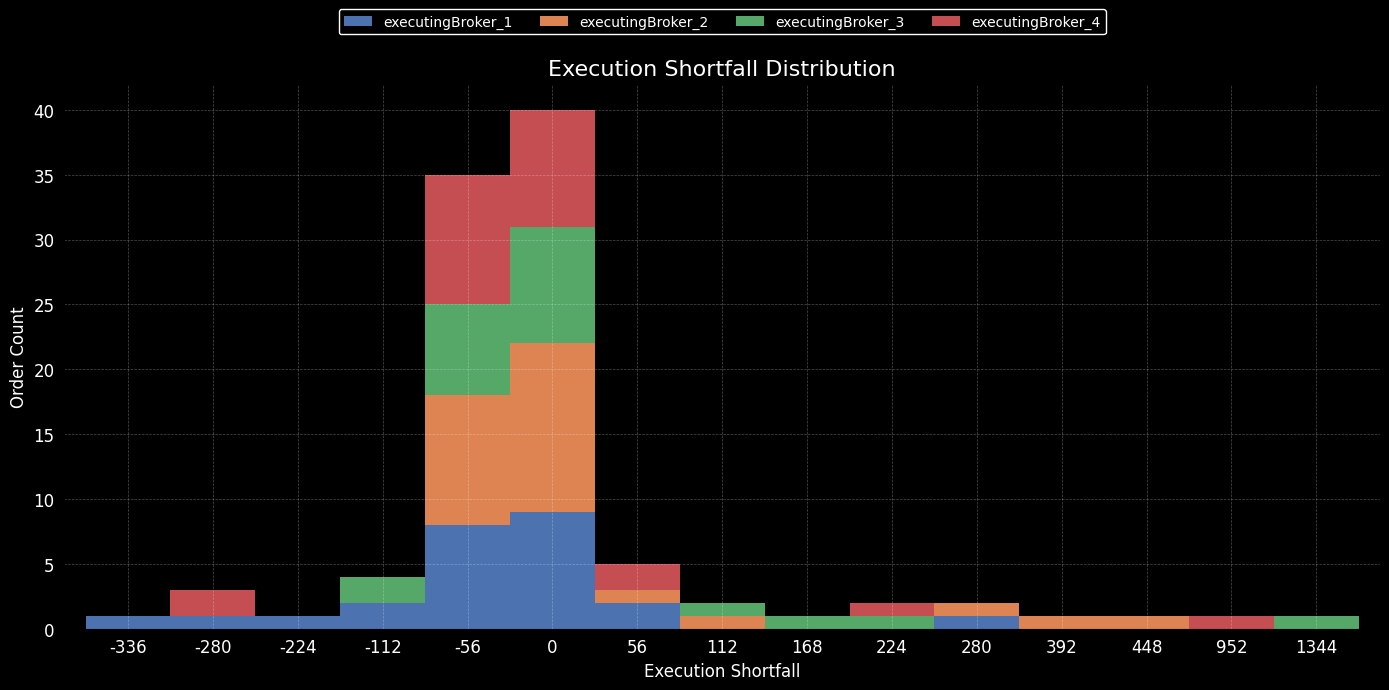

In [21]:
executionShortFallData = dfPayloadSumAnalyticsCustom.copy()

# executionShortfall bins
data_min = executionShortFallData['executionShortfall'].min()
data_max = executionShortFallData['executionShortfall'].max()
step_size = 56  # Adjust bin width as needed
bin_edges = np.arange(np.floor(data_min / step_size) * step_size, np.ceil(data_max / step_size) * step_size + step_size, step_size)
executionShortFallData['bins'] = pd.cut(executionShortFallData['executionShortfall'], bins=bin_edges)

# Group data by bin
grouped = executionShortFallData.groupby(['bins', 'executingBrokerCode'], observed=True).size().unstack(fill_value=0)

# Plot setup
plt.figure(figsize=(14, 7))
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
colors = sns.color_palette("deep", len(grouped.columns))

# Plot
grouped.plot(kind='bar', stacked=True, color=colors, ax=plt.gca(), width=1.0, position=1)

# Plot setup
plt.title("Execution Shortfall Distribution", fontsize=16, color="white")
plt.xlabel("Execution Shortfall", fontsize=12, color="white")
plt.ylabel("Order Count", fontsize=12, color="white")
x_labels = [f"{int(interval.left)}" for interval in grouped.index]
plt.xticks(ticks=np.arange(len(grouped)) - 0.5, labels=x_labels, rotation=0, ha='center', color="white", fontsize="12")
plt.yticks(color='white', fontsize="12")
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
plt.legend(
    title="",
    bbox_to_anchor=(0.5, 1.15),
    title_fontsize='12',
    fancybox=True,
    shadow=False,
    frameon=True,
    facecolor="black",
    edgecolor='white',
    labelcolor='white',
    markerfirst=True,
    loc='upper center',
    ncol=len(executionShortFallData['executingBrokerCode'].unique()),
    framealpha=1
    )
plt.tight_layout()
plt.show()

## Box Plot using Summary Data

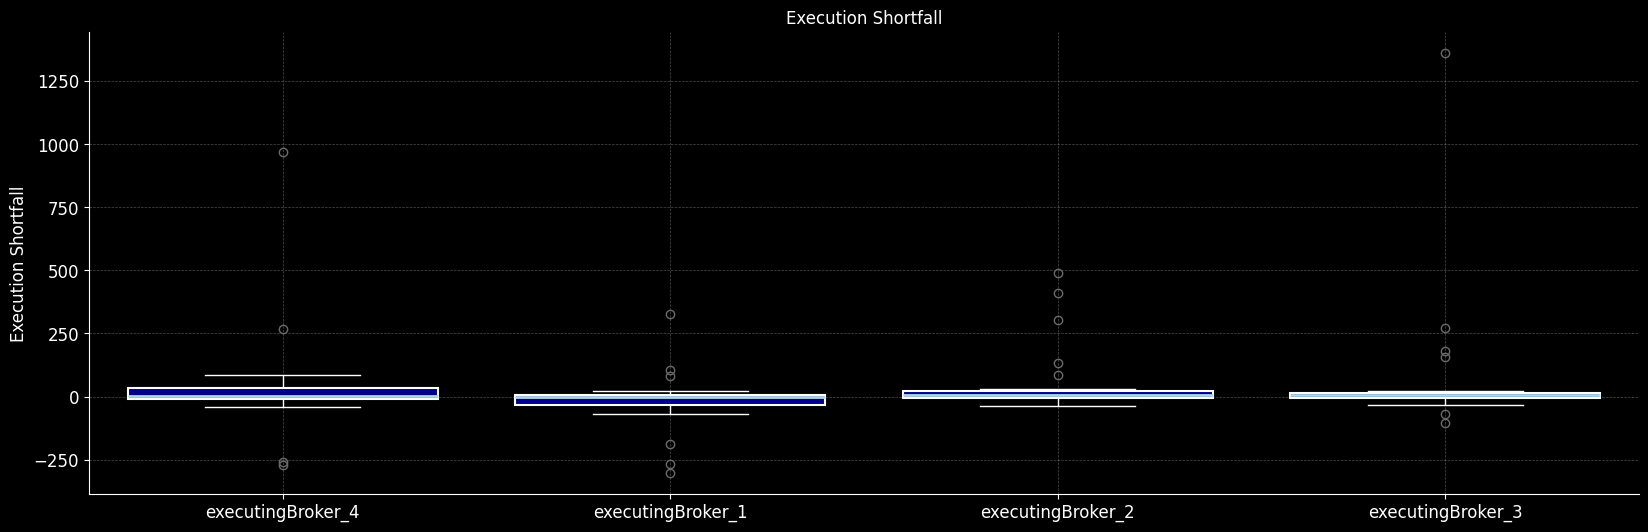

In [23]:
plt.figure(figsize=(20, 6))
plt.style.use('dark_background')
sns.boxplot(
    x='executingBrokerCode', y='executionShortfall', data=executionShortFallData,
    boxprops=dict(facecolor='darkblue', edgecolor='white', linewidth=1.5),
    medianprops=dict(color='lightblue', linewidth=2),
    whiskerprops=dict(color='white', linewidth=1),
    capprops=dict(color='white', linewidth=1)
)
plt.grid(True, color='white', linestyle='--', linewidth=0.5, alpha=0.3)
plt.title('Execution Shortfall')
plt.xlabel('', fontsize=18, color='white')
plt.xticks(color="white", fontsize="12")
plt.ylabel('Execution Shortfall', fontsize=12, color='white')
plt.yticks(color="white", fontsize="12")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.show()